In [1]:
    
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Pauli
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector, Operator
from qiskit.visualization import array_to_latex
from qiskit import Aer, execute
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.settings import QiskitNatureSettings

from qiskit_algorithms import TrotterQRTE
from qiskit_algorithms import TimeEvolutionProblem


QiskitNatureSettings.use_pauli_sum_op = False

import numpy as np

In [2]:
# Setup

M = 2  #Number of Localizations
N = 2*M #total number of operators (Two positions times two spin polarizations)

zero = Operator(np.zeros((2**N,2**N)))


In [3]:
Tu = Statevector.from_int(1, 2**N)
Td = Statevector.from_int(2, 2**N)
Bu = Statevector.from_int(4, 2**N)
Bd = Statevector.from_int(8, 2**N)
vac = Statevector.from_int(0, 2**N)

In [4]:
# Define the Fermionic Operators
op_list = [
    # ({second_q-operator: coefficient}, num_qubits)
    ({"+_0 -_1": 1.0}, 4),  # a^dagger_0 a_1
    ({"+_1 -_0": 1.0}, 4),  # a^dagger_1 a_0
    ({"+_2 -_3": 1.0}, 4),  
    ({"+_3 -_2": 1.0}, 4),  
    ({"+_0 -_0": 1.0}, 4),  
    ({"+_1 -_1": 1.0}, 4),  
    ({"+_2 -_2": 1.0}, 4),  
    ({"+_3 -_3": 1.0}, 4),  
    ({"+_0 -_2": 1.0}, 4),  
    ({"+_1 -_3": 1.0}, 4),  
    ({"+_2 -_0": 1.0}, 4),  
    ({"+_3 -_1": 1.0}, 4),  
    
]


In [5]:
# Define spin operators
# Notice that spin operators are defined for top and bottom layer
sig_x = [zero, zero]
sig_x[0] = JordanWignerMapper().map(FermionicOp(op_list[1][0], num_spin_orbitals=N)) + JordanWignerMapper().map(FermionicOp(op_list[0][0], num_spin_orbitals=N))
sig_x[1] = JordanWignerMapper().map(FermionicOp(op_list[3][0], num_spin_orbitals=N)) + JordanWignerMapper().map(FermionicOp(op_list[2][0], num_spin_orbitals=N))

sig_y = [zero, zero]
sig_y[0] = 1j*JordanWignerMapper().map(FermionicOp(op_list[1][0], num_spin_orbitals=N)) - 1j*JordanWignerMapper().map(FermionicOp(op_list[0][0], num_spin_orbitals=N))
sig_y[1] = 1j*JordanWignerMapper().map(FermionicOp(op_list[3][0], num_spin_orbitals=N)) - 1j*JordanWignerMapper().map(FermionicOp(op_list[2][0], num_spin_orbitals=N))

sig_z = [zero, zero]
sig_z[0] = JordanWignerMapper().map(FermionicOp(op_list[4][0], num_spin_orbitals=N)) - JordanWignerMapper().map(FermionicOp(op_list[5][0], num_spin_orbitals=N))
sig_z[1] = JordanWignerMapper().map(FermionicOp(op_list[6][0], num_spin_orbitals=N)) - JordanWignerMapper().map(FermionicOp(op_list[7][0], num_spin_orbitals=N))


# Define position operators
# Notice

pos_x = [zero, zero]
pos_x[0] = JordanWignerMapper().map(FermionicOp(op_list[8][0], num_spin_orbitals=N)) + JordanWignerMapper().map(FermionicOp(op_list[10][0], num_spin_orbitals=N))
pos_x[1] = JordanWignerMapper().map(FermionicOp(op_list[11][0], num_spin_orbitals=N)) + JordanWignerMapper().map(FermionicOp(op_list[9][0], num_spin_orbitals=N))

pos_y = [zero, zero]
pos_y[0] = 1j*JordanWignerMapper().map(FermionicOp(op_list[8][0], num_spin_orbitals=N)) - 1j*JordanWignerMapper().map(FermionicOp(op_list[10][0], num_spin_orbitals=N))
pos_y[1] = 1j*JordanWignerMapper().map(FermionicOp(op_list[11][0], num_spin_orbitals=N)) - 1j*JordanWignerMapper().map(FermionicOp(op_list[9][0], num_spin_orbitals=N))


pos_z = [zero, zero]
pos_z[0] = JordanWignerMapper().map(FermionicOp(op_list[4][0], num_spin_orbitals=N)) - JordanWignerMapper().map(FermionicOp(op_list[6][0], num_spin_orbitals=N))
pos_z[1] = JordanWignerMapper().map(FermionicOp(op_list[5][0], num_spin_orbitals=N)) - JordanWignerMapper().map(FermionicOp(op_list[7][0], num_spin_orbitals=N))



In [6]:
# Define additional Hamiltonian terms

#total spin operators
Sx,Sy,Sz=0,0,0
for i in range(M):
    Sx += sig_x[i]
    Sy += sig_y[i]
    Sz += sig_z[i]


Sx = Sx.simplify()
Sy = Sy.simplify()
Sz = Sz.simplify()

    
#total location pauli operators
Lx,Ly,Lz=0,0,0
for i in range(2):
    Lx += pos_x[i]
    Ly += pos_y[i]
    Lz += pos_z[i]

Lx = Lx.simplify()
Ly = Ly.simplify()
Lz = Lz.simplify()




In [7]:
# Hamiltonian terms

def H_chargesplit(E):
    return E*Lz

def H_spinsplit(E):
    return E*Sz
    
def H_EDSR(alpha,w,t, phi=0):
    # return lambda t: (alpha[0]*sig_x[0]+alpha[1]*sig_x[1])/2*np.cos(w*t+phi) #+detune*Sz
    # return lambda t: (alpha[0]*(sig_x[0]).simplify+alpha[1]*(sig_x[1]).simplify())/2*np.cos(w*t+phi)  # included h.c. to make it hermitian
    return (alpha[0]*sig_x[0].simplify()+alpha[1]*sig_x[1].simplify())/2*np.cos(w*t+phi)

def H_EDSR_no_time(alpha):
    return (alpha[0]*sig_x[0].simplify()+alpha[1]*sig_x[1].simplify())/2
    
def H_LZSI(eps,w, t, phi=0):
    return eps/2*Lx#*np.cos(w*t+phi) #+detune*Lz


In [10]:
# Implement colour map

E_charge_list = np.linspace(-18,18, 10)
waiting_time_list = np.linspace(25, 100, 10)

# Sequence consists of 3 blocks
# 1. Charge splitting
# 2. Waiting time and Bloch rotation
# 3. Charge splitting

E_charge= -400
E_spin  = 1
E_charge_drive= 0

w_charge = E_charge*2
w_spin   = E_spin*2

hbar = 6.582119569e2 #ueV*ps
alpha= (.1,0)
alph = .1
eps  = 11

drivetime= 57/hbar 



In [14]:
################################ Block 1

initial_state = Tu

num_steps_block1 = 50
T_block1_list = np.linspace(0, drivetime, num_steps_block1)
delta_t_block1 = T_block1_list[1] - T_block1_list[0]

# Prepate H_0 
H_0_list = []
for t in T_block1_list:
    H_0_list.append(H_spinsplit(E_spin) + H_chargesplit(E_charge + (E_charge_drive-E_charge)*t/drivetime))

# Store states after every time step

states_block1 = []
states_block1.append(initial_state)

print('Running block 1...')

for i in tqdm(range(num_steps_block1-1)):
    problem = TimeEvolutionProblem(H_0_list[i] + H_LZSI(eps, w_spin, 0), initial_state=states_block1[-1], time=delta_t_block1)
    trotter = TrotterQRTE(num_timesteps=1)
    result = trotter.evolve(problem)    
    states_block1.append(Statevector(result.evolved_state))



prob_dict_block1 = {'0001':[], '0010':[], '0100':[], '1000':[]}

for states in states_block1:
    if len(states.probabilities_dict())==1:
        prob_dict_block1['0001'].append(1)
        prob_dict_block1['0010'].append(0)
        prob_dict_block1['0100'].append(0)
        prob_dict_block1['1000'].append(0)
    else:
        for key in prob_dict_block1.keys():
            prob_dict_block1[key].append(states.probabilities_dict()[key])


################################## Block 2

initial_state = states_block1[-1]

num_steps_block2 = 50
T_block2_list = np.linspace(0, 1, num_steps_block2)
delta_t_block2 = T_block2_list[1] - T_block2_list[0]

# Store states after every time step

states_block2 = []
states_block2.append(states_block1[-1])


print('Running block 2...')
for i in tqdm(range(num_steps_block2-1)):
    problem = TimeEvolutionProblem(H_spinsplit(E_spin) + H_chargesplit(E_charge_drive) + H_LZSI(eps, w_spin, 0), initial_state=states_block2[-1], time=delta_t_block2)
    trotter = TrotterQRTE(num_timesteps=1)
    result = trotter.evolve(problem)    
    states_block2.append(Statevector(result.evolved_state))


prob_dict_block2 = {'0000': [], '0001': [], '0010': [], '0011': [], 
                    '0100': [], '0101': [], '0110': [], '0111': [], 
                    '1000': [], '1001': [], '1010': [], '1011': [], 
                    '1100': [], '1101': [], '1110': [], '1111': []}

for states in states_block2:
    for key in states.probabilities_dict().keys():
        if states.probabilities_dict()[key] < 1e-15:
            prob_dict_block2[key].append(0)
        else:
            prob_dict_block2[key].append(states.probabilities_dict()[key])
    for key in prob_dict_block2.keys():
        if key not in states.probabilities_dict().keys():
            prob_dict_block2[key].append(0)



################################## Block 3

initial_state = states_block2[-1]

num_steps_block3 = 50
T_block3_list = np.linspace(0, drivetime, num_steps_block3)
delta_t_block3 = T_block3_list[1] - T_block3_list[0]

# Prepare H_0
H_0_list = []
for t in T_block3_list:
    H_0_list.append(H_spinsplit(E_spin) + H_chargesplit(E_charge_drive + (E_charge-E_charge_drive)*t/drivetime))

# Store states after every time step

states_block3 = []
states_block3.append(states_block2[-1])

print('Running block 3...')
for i in tqdm(range(num_steps_block3-1)):
    problem = TimeEvolutionProblem(H_0_list[i] + H_LZSI(eps, w_spin, 0), initial_state=states_block3[-1], time=delta_t_block3)
    trotter = TrotterQRTE(num_timesteps=1)
    result = trotter.evolve(problem)    
    states_block3.append(Statevector(result.evolved_state))


prob_dict_block3 = {'0000': [], '0001': [], '0010': [], '0011': [], 
                    '0100': [], '0101': [], '0110': [], '0111': [], 
                    '1000': [], '1001': [], '1010': [], '1011': [], 
                    '1100': [], '1101': [], '1110': [], '1111': []}

for states in states_block3:
    for key in states.probabilities_dict().keys():
        if states.probabilities_dict()[key] < 1e-15:
            states_block3[key].append(0)
        else:
            states_block3[key].append(states.probabilities_dict()[key])
    for key in prob_dict_block2.keys():
        if key not in states.probabilities_dict().keys():
            states_block3[key].append(0)


# Plot the probabilities of the states in the computational basis vs time
plt.figure()
plt.plot(T_block3_list, np.array(prob_dict_block3['0001']), label='0001')
plt.plot(T_block3_list, np.array(prob_dict_block3['0010']), label='0010')
plt.plot(T_block3_list, np.array(prob_dict_block3['0100']), label='0100')
plt.plot(T_block3_list, np.array(prob_dict_block3['1000']), label='1000')
plt.legend()
plt.show()


Running block 1...


  0%|          | 0/49 [00:00<?, ?it/s]

Running block 2...


  0%|          | 0/49 [00:00<?, ?it/s]

Running block 3...


  0%|          | 0/49 [00:00<?, ?it/s]

TypeError: list indices must be integers or slices, not numpy.str_

Running block 2...


  0%|          | 0/49 [00:00<?, ?it/s]

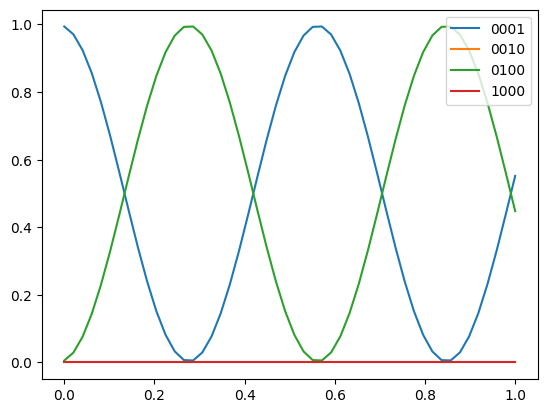

In [12]:
# Block 2

initial_state = states_block1[-1]

num_steps_block2 = 50
T_block2_list = np.linspace(0, 1, num_steps_block2)
delta_t_block2 = T_block2_list[1] - T_block2_list[0]

# Store states after every time step

states_block2 = []
states_block2.append(states_block1[-1])


print('Running block 2...')
for i in tqdm(range(num_steps_block2-1)):
    problem = TimeEvolutionProblem(H_spinsplit(E_spin) + H_chargesplit(E_charge_drive) + H_LZSI(eps, w_spin, 0), initial_state=states_block2[-1], time=delta_t_block2)
    trotter = TrotterQRTE(num_timesteps=1)
    result = trotter.evolve(problem)    
    states_block2.append(Statevector(result.evolved_state))


prob_dict_block2 = {'0000': [], '0001': [], '0010': [], '0011': [], 
                    '0100': [], '0101': [], '0110': [], '0111': [], 
                    '1000': [], '1001': [], '1010': [], '1011': [], 
                    '1100': [], '1101': [], '1110': [], '1111': []}

for states in states_block2:
    for key in states.probabilities_dict().keys():
        if states.probabilities_dict()[key] < 1e-15:
            prob_dict_block2[key].append(0)
        else:
            prob_dict_block2[key].append(states.probabilities_dict()[key])
    for key in prob_dict_block2.keys():
        if key not in states.probabilities_dict().keys():
            prob_dict_block2[key].append(0)


# Plot the probabilities of the states in the computational basis vs time
plt.figure()
plt.plot(T_block2_list, np.array(prob_dict_block2['0001']), label='0001')
plt.plot(T_block2_list, np.array(prob_dict_block2['0010']), label='0010')
plt.plot(T_block2_list, np.array(prob_dict_block2['0100']), label='0100')
plt.plot(T_block2_list, np.array(prob_dict_block2['1000']), label='1000')
plt.legend()
plt.show()

In [13]:
# Block 3

initial_state = states_block2[-1]

num_steps_block3 = 50
T_block3_list = np.linspace(0, drivetime, num_steps_block3)
delta_t_block3 = T_block3_list[1] - T_block3_list[0]

# Prepare H_0
H_0_list = []
for t in T_block3_list:
    H_0_list.append(H_spinsplit(E_spin) + H_chargesplit(E_charge_drive + (E_charge-E_charge_drive)*t/drivetime))

# Store states after every time step

states_block3 = []
states_block3.append(states_block2[-1])

print('Running block 3...')
for i in tqdm(range(num_steps_block3-1)):
    problem = TimeEvolutionProblem(H_0_list[i] + H_LZSI(eps, w_spin, 0), initial_state=states_block3[-1], time=delta_t_block3)
    trotter = TrotterQRTE(num_timesteps=1)
    result = trotter.evolve(problem)    
    states_block3.append(Statevector(result.evolved_state))


prob_dict_block3 = {'0001': [], '0010': [], '0100': [], '1000': []}

for states in states_block3:
    for key in states.probabilities_dict().keys():
        if states.probabilities_dict()[key] < 1e-15:
            prob_dict_block3[key].append(0)
        else:
            prob_dict_block3[key].append(states.probabilities_dict()[key])
    for key in prob_dict_block3.keys():
        if key not in states.probabilities_dict().keys():
            prob_dict_block3[key].append(0)

Running block 3...


  0%|          | 0/49 [00:00<?, ?it/s]

KeyError: '0000'